In [112]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/training.1600000.processed.noemoticon.csv', 'r', encoding='utf-8', errors='ignore') as file:
  split_columns=pd.read_csv(file,names=['target', 'id', 'date', 'flag', 'user', 'text'])

In [ ]:
split_columns.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
split_columns.isnull().sum()


target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
split_columns.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '',text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    text = ' '.join(tokens)
    # Join tokens back into text   # Remove extra spaces
    return text.strip().lower()

In [ ]:
split_columns['cleaned_text'] =split_columns['text'].apply(clean_text)

In [ ]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()


In [ ]:
# Function to analyze sentiment
def analyze_sentiment(tweet):
    scores = sid.polarity_scores(tweet)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
# Apply the analyze_sentiment function
split_columns['sentiment'] = split_columns['cleaned_text'].apply(analyze_sentiment)

In [ ]:
# Display the sentiment counts
print(split_columns['sentiment'].value_counts())

sentiment
positive    767280
neutral     421553
negative    411167
Name: count, dtype: int64


<ipython-input-92-48cfcf3bc8e5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=split_columns, palette='viridis')


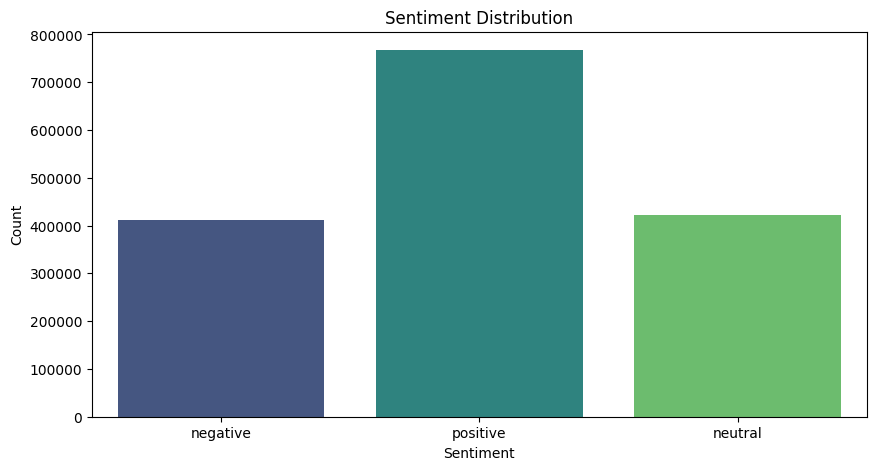

In [ ]:


# Count plot for sentiment distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='sentiment', data=split_columns, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [ ]:
#need to encode
label_encoder = LabelEncoder()
label_encoder.fit(split_columns['sentiment'])
label_encoder.transform(split_columns['sentiment'])

array([0, 0, 2, ..., 2, 2, 2])

In [ ]:
split_columns.shape

(1600000, 8)

In [ ]:
split_columns.cleaned_text.shape

(1600000,)

In [ ]:
split_columns.sentiment.shape

(1600000,)

In [ ]:
# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(split_columns['cleaned_text'])

In [ ]:
y = split_columns['sentiment']

In [ ]:
X.shape

(168542, 60502)

In [ ]:
y.shape

(1600000,)

In [ ]:
y = y[:X.shape[0]]

In [ ]:
X.shape

(168542, 60502)

In [ ]:
y.shape

(168542,)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model (Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.3842000652644694
Classification Report:
              precision    recall  f1-score   support

    negative       0.41      0.71      0.52     13858
     neutral       0.25      0.07      0.11      8514
    positive       0.34      0.22      0.27     11337

    accuracy                           0.38     33709
   macro avg       0.33      0.33      0.30     33709
weighted avg       0.35      0.38      0.33     33709



In [ ]:
svm_classifier = SVC(kernel='linear', C=1.0)

# Train SVM classifier
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)